In [17]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
import random
from sklearn.metrics import classification_report
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
from statsmodels.stats.multitest import fdrcorrection_twostage
%matplotlib inline

In [2]:
df_train = pd.read_csv("drugsComTrain_raw.csv")
df_test = pd.read_csv("drugsComTest_raw.csv")
df_train['sentiment'] = df_train['rating'].apply(lambda x: 1 if x>5 else 0)
df_test['sentiment'] = df_test['rating'].apply(lambda x: 1 if x>5 else 0)

In [5]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


In [3]:
df_train.groupby('sentiment').size()

sentiment
0     48088
1    113209
dtype: int64

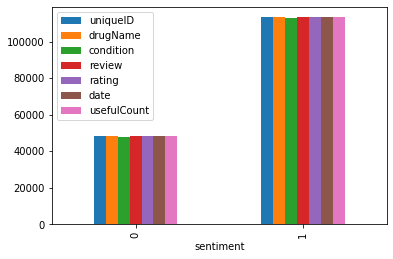

In [4]:
df_train.groupby('sentiment').count().plot.bar()

In [10]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['month'] = df_train['date'].apply(lambda x: x.month)

Text(0.5, 1.0, 'Number of comments posting against date')

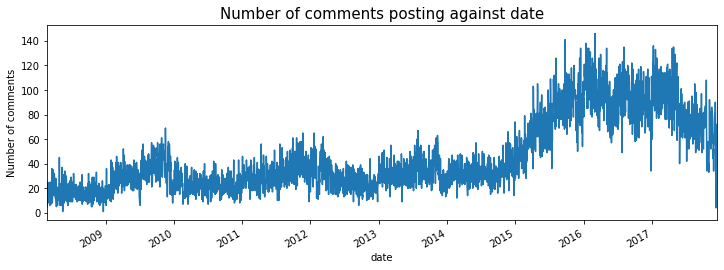

In [9]:
df_train.groupby('date').size().plot(figsize=(12,4))
plt.ylabel('Number of comments')
plt.title("Number of comments posting against date",fontsize=15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

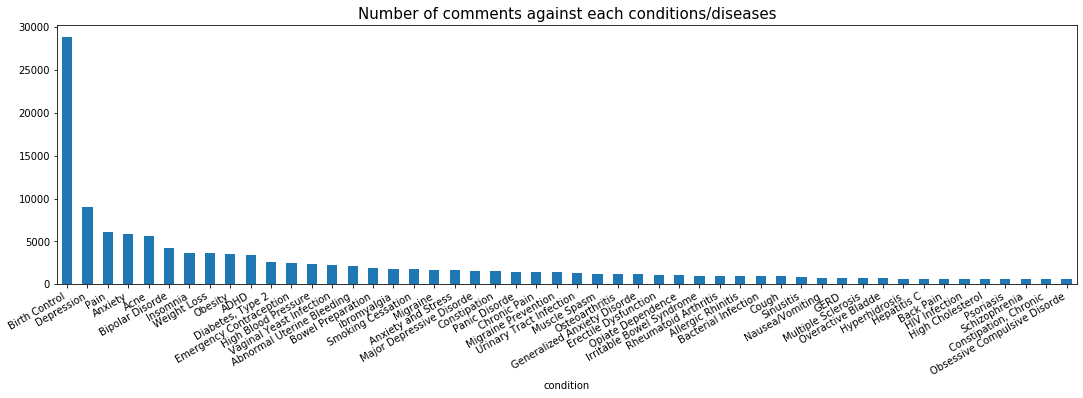

In [12]:
df_con_mon = pd.DataFrame(df_train.groupby(['condition','month']).size()).reset_index()

df_comments = df_con_mon.pivot_table(index='condition',columns='month',values=0)

fig = plt.figure(figsize=(15,5))
df_comments.sum(1).sort_values(ascending=False).iloc[:50].plot(kind='bar')
plt.title("Number of comments against each conditions/diseases",fontsize=15)
plt.tight_layout()
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.xticks(fontsize=10)

# plt.savefig("Plot/num_comments_each_condition.png")

Total number of comments for each condition

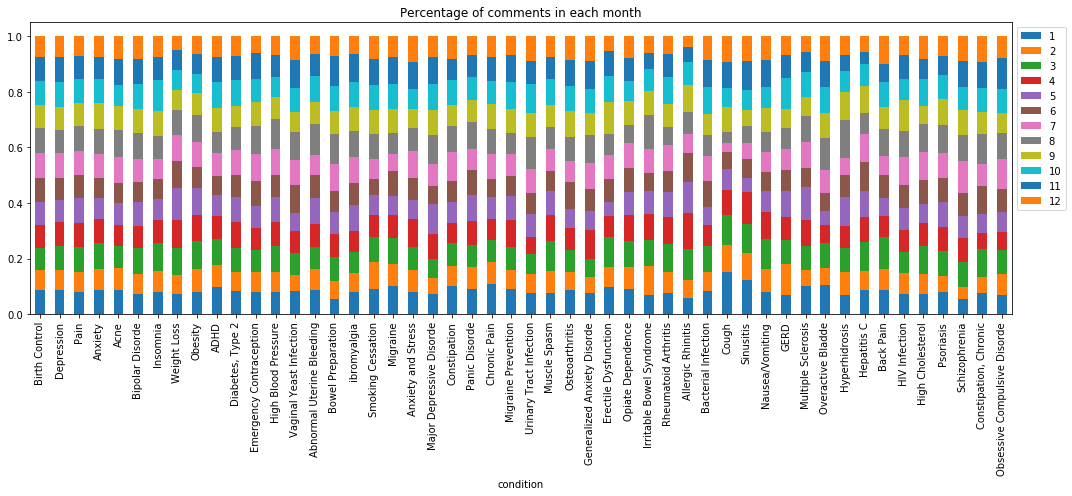

In [14]:
n = 50
top_n_index = df_comments.sum(1).sort_values(ascending=False).iloc[:n].index
top_cmts = df_comments.loc[top_n_index]
top_cmts_per = top_cmts.div(top_cmts.sum(1), axis=0)
top_cmts_per.plot.bar(stacked=True, figsize=(15,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Percentage of comments in each month")
plt.tight_layout()

In [15]:
## avg of comments for each condition in each month
df_comments_sorted = df_comments.loc[df_comments.sum(1).sort_values(ascending=False).index]

df_comments_sorted.sum() / len(df_comments_sorted)
#mon_sick_per = df_con_mon_pivot_sorted.sum()/df_con_mon_pivot_sorted.sum().sum()

month
1     15.356335
2     13.541855
3     15.686652
4     15.442308
5     15.020362
6     14.348416
7     15.580317
8     16.380090
9     15.158371
10    15.804299
11    15.606335
12    13.520362
dtype: float64

In [18]:
sum_months = df_comments_sorted.sum()
all_sum = sum_months.sum()

i = 0 
#df_con_mon_pivot_sorted.iloc[i,:]
expected = df_comments_sorted.sum(0) * (df_comments_sorted.iloc[i,:].sum() / all_sum)
observed = df_comments_sorted.iloc[i,:]
chisquare(observed,f_exp=expected)

Power_divergenceResult(statistic=38.935465364569865, pvalue=5.4327938627447377e-05)

In [19]:

sum_months = df_comments_sorted.sum()
all_sum = sum_months.sum()
chi_result =[]

## only take T > 5 (the cell need 5 records at least)
df_comments_sorted_T5 = df_comments_sorted[(df_comments_sorted > 5).all(1)]
df_comments_sorted_T5.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
condition,,,,,,,,,,,,
Birth Control,2458.0,2089.0,2327.0,2356.0,2441.0,2477.0,2542.0,2627.0,2348.0,2492.0,2494.0,2137.0
Depression,773.0,684.0,753.0,808.0,712.0,707.0,823.0,740.0,749.0,827.0,819.0,674.0
Pain,489.0,443.0,563.0,529.0,537.0,506.0,541.0,556.0,514.0,519.0,514.0,434.0
Anxiety,522.0,445.0,546.0,515.0,431.0,441.0,496.0,547.0,538.0,511.0,464.0,448.0
Acne,490.0,429.0,444.0,435.0,431.0,412.0,518.0,542.0,477.0,437.0,511.0,462.0


In [20]:
## compare expected and observed using chi-square test
for idx in df_comments_sorted_T5.index:
    ## use 
    expected = df_comments_sorted.sum(0) * (df_comments_sorted.loc[idx,:].sum() / all_sum)
    observed = df_comments_sorted_T5.loc[idx,:]
    
    chi_result.append([idx,chisquare(observed,f_exp=expected)])

In [21]:
df_chi = pd.DataFrame([[a[0],a[1].statistic,a[1].pvalue] for a in chi_result])
df_chi.columns = ['condition','statistic','pvalue']
df_chi['adj_pvalue'] = fdrcorrection_twostage(df_chi['pvalue'])[1]
df_chi.head()

,condition,statistic,pvalue,adj_pvalue
0,Birth Control,38.935465,0.000054,0.000293
1,Depression,19.054616,0.060120,0.083805
2,Pain,9.238257,0.599910,0.425463
3,Anxiety,20.705844,0.036550,0.056828
4,Acne,29.811602,0.001696,0.004424


In [22]:
df_chi_sorted = df_chi[df_chi['adj_pvalue'] < 0.05].sort_values('pvalue')

df_chi_sorted.head(10)

,condition,statistic,pvalue,adj_pvalue
7,Weight Loss,145.652500,1.149992e-25,9.297688e-24
35,Cough,129.962039,1.771886e-22,7.162849e-21
33,Allergic Rhinitis,89.940100,1.712822e-14,4.616054e-13
36,Sinusitis,72.581047,3.936670e-11,7.956994e-10
72,Cough and Nasal Congestion,71.094673,7.562344e-11,1.222831e-09
68,Herpes Simplex,57.745517,2.424612e-08,3.267165e-07
8,Obesity,54.759136,8.577515e-08,9.907030e-07
6,Insomnia,53.858426,1.252668e-07,1.265978e-06
53,Bronchitis,50.674949,4.731868e-07,4.250795e-06
13,Vaginal Yeast Infection,48.344293,1.239355e-06,1.002018e-05


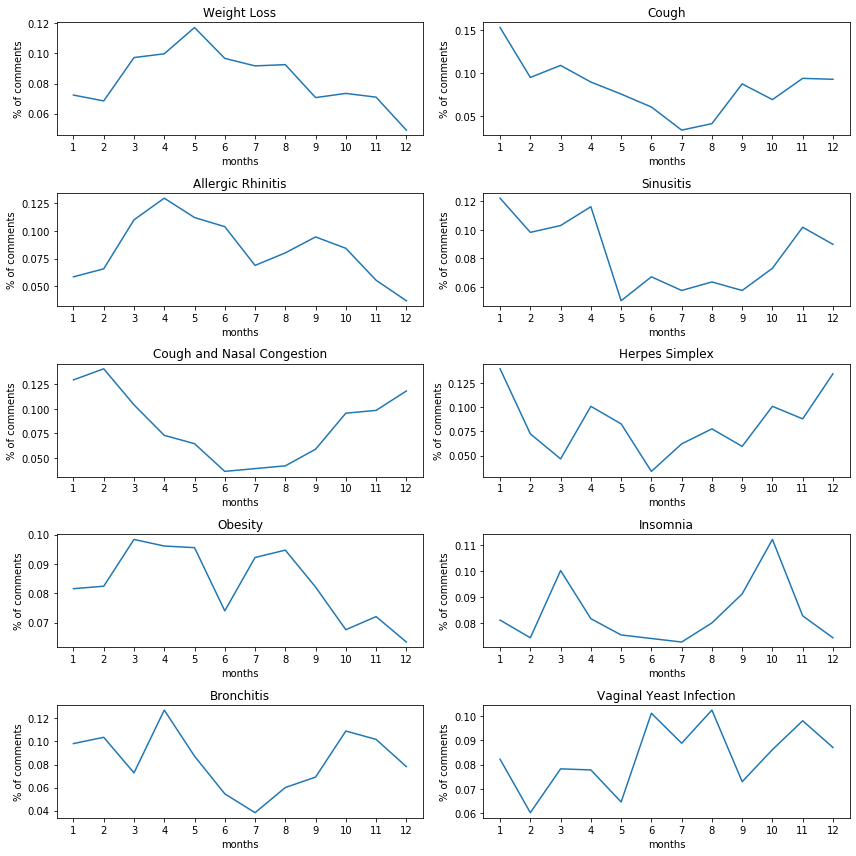

In [25]:
plt.figure(figsize=(12,12))
i =1
for idx in df_chi_sorted['condition'][:10]:
    
    each = df_comments_sorted_T5.loc[idx,:]/df_comments_sorted_T5.loc[idx,:].sum()
    
    plt.subplot(5, 2, i)
    plt.title(idx)
    plt.plot(each)
    plt.xticks(np.arange(1,13,1))
    plt.xlabel('months')
    plt.ylabel('% of comments')
    i = i +1
    
plt.tight_layout()